# Landau-Zener Problem as Benchmark

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from qopt import *
import qopt.tensorflow_optimize
import qopt.tensorflow_simulator
import qopt.tensorflow_cost_func
import qopt.tensorflow_solver_algs
from qopt.tensorflow_util import DEFAULT_FLOAT_TYPE, DEFAULT_COMPLEX_TYPE

from importlib import reload
reload(qopt.tensorflow_simulator)
reload(qopt.tensorflow_solver_algs)
reload(qopt.tensorflow_cost_func)
reload(qopt.tensorflow_optimize)

from scipy.constants import physical_constants, elementary_charge, giga, \
    micro

# ############################ Physical Constants #############################

hbar = physical_constants["reduced Planck constant"][0]
micro_eV_by_inverse_nano_seconds = elementary_charge / hbar / giga * micro


total_time = .1 / 5
n_time_steps = 200
delta_t = total_time / n_time_steps
tunnel_coupling = 100 * micro_eV_by_inverse_nano_seconds

minimal_detuning = - 1000 * micro_eV_by_inverse_nano_seconds
maximal_detuning = 1000 * micro_eV_by_inverse_nano_seconds
initial_detuning = minimal_detuning
final_detuning = maximal_detuning
boundaries = np.zeros(shape=(n_time_steps, 2), dtype=float)
boundaries[:, 0] = minimal_detuning
boundaries[:, 1] = maximal_detuning

# We want to ensure a transition, so we need to make sure that the final and initial values are fixed:
boundaries[0, 1] = minimal_detuning
boundaries[-1, 0] = maximal_detuning

h_ctrl = [-.5 * DenseOperator.pauli_z()]
h_drift = n_time_steps * [-.5 * tunnel_coupling * DenseOperator.pauli_x()]

tau = delta_t * np.ones(n_time_steps)

In [3]:
initial_hamiltonian = initial_detuning * h_ctrl[0] + h_drift[0]
eig_vals_inital_ham, eig_vecs_inital_ham = initial_hamiltonian.spectral_decomposition(hermitian=True)

final_hamiltonian = final_detuning * h_ctrl[0] + h_drift[-1]
eig_vals_final_ham, eig_vecs_final_ham = final_hamiltonian.spectral_decomposition(hermitian=True)

initial_state_vector = np.expand_dims(eig_vecs_inital_ham[:, 0], axis=1)
final_state_vector = np.expand_dims(eig_vecs_final_ham[:, 0], axis=1)




In [4]:
solver = qopt.tensorflow_solver_algs.TensorFlowSolver(
    h_ctrl=h_ctrl,
    h_drift=h_drift,
    tau=tau,
    initial=initial_state_vector  # We start in the ground state
)

cost_func = qopt.tensorflow_cost_func.TensorFlowStateInfidelity(
    target=final_state_vector,  # We want to terminate in the instantaneous ground state
    solver=solver
)

simulator = qopt.tensorflow_simulator.TensorFlowSimulator(
    solver=solver,
    cost_func=cost_func
)

optimizer = qopt.tensorflow_optimize.TensorFlowScipyOptimizer(
    simulator=simulator,
    boundaries=None
)

In [5]:
initial_values = np.linspace(minimal_detuning, maximal_detuning, n_time_steps, endpoint=True)
initial_values_tf = np.expand_dims(initial_values, axis=1)
initial_values_tf = tf.constant(initial_values_tf, dtype=DEFAULT_FLOAT_TYPE)


simulator.value_and_gradient(opt_pars=tf.Variable(initial_values_tf, dtype=DEFAULT_FLOAT_TYPE))

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.79326928]])>,
 <tf.Tensor: shape=(200, 1), dtype=complex128, numpy=
 array([[-3.27766280e-06-2.29076426e-05j],
        [-3.59513493e-06-2.23820089e-05j],
        [-3.82984165e-06-2.18144920e-05j],
        [-3.97732917e-06-2.12182087e-05j],
        [-4.03522301e-06-2.06065255e-05j],
        [-4.00318022e-06-1.99927418e-05j],
        [-3.88279657e-06-1.93897959e-05j],
        [-3.67747474e-06-1.88099992e-05j],
        [-3.39226003e-06-1.82648029e-05j],
        [-3.03365010e-06-1.77645996e-05j],
        [-2.60938568e-06-1.73185623e-05j],
        [-2.12822861e-06-1.69345213e-05j],
        [-1.59973353e-06-1.66188780e-05j],
        [-1.03401894e-06-1.63765558e-05j],
        [-4.41542857e-07-1.62109840e-05j],
        [ 1.67112352e-07-1.61241146e-05j],
        [ 7.81442055e-07-1.61164663e-05j],
        [ 1.39120515e-06-1.61871946e-05j],
        [ 1.98659107e-06-1.63341823e-05j],
        [ 2.55836616e-06-1.65541482e-05j],
        [ 3.09

In [6]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

In [7]:
# Launch TensorBoard and navigate to the Profile tab to view performance profile
# %tensorboard --logdir=logs

In [8]:
1+1

2

In [29]:


start = time.time()
# with tf.device("/cpu:0"):
for i in range(7):
    result = optimizer.run_optimization(initial_values)
end = time.time()
duration = end - start
print(duration)

64.546142578125


In [10]:
import cProfile
import pstats


cProfile.run('simulator.value_and_gradient(opt_pars=tf.Variable(initial_values_tf, dtype=DEFAULT_FLOAT_TYPE))')

         792 function calls (753 primitive calls) in 0.048 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<lambda>)
        1    0.000    0.000    0.048    0.048 <string>:1(<module>)
       19    0.000    0.000    0.000    0.000 abc.py:117(__instancecheck__)
        4    0.000    0.000    0.000    0.000 abc.py:121(__subclasscheck__)
        1    0.000    0.000    0.000    0.000 compat.py:61(as_bytes)
        1    0.000    0.000    0.000    0.000 context.py:1256(function_call_options)
        1    0.000    0.000    0.000    0.000 context.py:198(executor_type)
        2    0.000    0.000    0.000    0.000 context.py:206(config_proto_serialized)
       12    0.000    0.000    0.000    0.000 context.py:2131(context_safe)
        8    0.000    0.000    0.000    0.000 context.py:2161(executing_eagerly)
        1    0.000    0.000    0.000    0.000 context.py:2290(anonymous

In [11]:
start = time.time()
for i in range(100):
    simulator.value_and_gradient(opt_pars=tf.Variable(initial_values_tf, dtype=DEFAULT_FLOAT_TYPE))
end = time.time()
print(end - start)

4.8173887729644775


In [12]:
stats = None

In [13]:
result = optimizer.run_optimization(initial_values)

In [14]:
result.nfev

167

In [15]:
result.fun * 1e3

0.02963974710779027

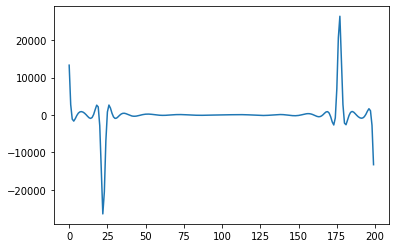

In [16]:
plt.plot(result.x)
plt.savefig(r'C:\Users\julia\Desktop\Work\Documentation\2022_08_21_Tensorflow_qopt\SamplePicture\second_result.pdf')

In [17]:
result

      fun: 2.963974710779027e-05
 hess_inv: <200x200 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.76369620e-09, -4.90089394e-10, -1.18191403e-09, -1.42213548e-09,
       -4.72578099e-10,  1.25368516e-09,  3.12246593e-09,  4.63592475e-09,
        5.51297512e-09,  5.67857813e-09,  5.22741519e-09,  4.38386507e-09,
        3.46283697e-09,  2.81893161e-09,  2.75907993e-09,  3.40420763e-09,
        4.53325072e-09,  5.49191880e-09,  5.29014988e-09,  3.18200379e-09,
       -1.86907584e-11, -6.31026481e-11,  5.57187175e-09,  2.13179482e-09,
       -1.16826161e-09,  9.65190077e-10,  3.24067373e-09,  3.72473379e-09,
        2.78159253e-09,  1.41156575e-09,  3.91741302e-10,  6.35642306e-11,
        3.89744864e-10,  1.11080635e-09,  1.90904680e-09,  2.52317206e-09,
        2.80417824e-09,  2.72420454e-09,  2.35331442e-09,  1.82042706e-09,
        1.27303753e-09,  8.44702697e-10,  6.33473456e-10,  6.91263284e-10,
        1.02286810e-09,  1.59254027e-09,  2.33534384e-09,  3.17037220e-

In [18]:
simulator.value_and_gradient(opt_pars=tf.Variable(np.expand_dims(result.x, axis=1), dtype=DEFAULT_FLOAT_TYPE))[0]


<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.96397471e-05]])>

### Acknowledgements

I thank Alessandro David for the suggestion of the Landau-Zener problem for benchmarking.

## Let's compare to native qopt

I leave this for now, but it might be a bit boring, if the results coincide exactly.


In [80]:
solver_qopt = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=tau,
    initial_state=DenseOperator(initial_state_vector)
)

cost_func_qopt = StateInfidelity(
    target=DenseOperator(final_state_vector),  # We want to terminate in the instantaneous ground state
    solver=solver_qopt
)

simulator_qopt = Simulator(
    solvers = [solver_qopt, ],
    cost_funcs = [cost_func_qopt, ]
)

from qopt.optimize import default_termination_conditions
termination_conditions = default_termination_conditions
termination_conditions['min_cost_gain'] = 1e-9
termination_conditions['min_gradient_norm'] = 1e-9
termination_conditions['min_amplitude_change'] = 1e-9

optimizer_qopt = ScalarMinimizingOptimizer(
    system_simulator=simulator_qopt,
    bounds=None,
    termination_cond=termination_conditions
)

In [81]:
initial_values_2dim = np.expand_dims(initial_values, axis=1)
result_qopt = optimizer_qopt.run_optimization(initial_values_2dim)

In [82]:
start = time.time()
result_qopt = optimizer_qopt.run_optimization(initial_values_2dim)
end = time.time()
duration = end - start
print(duration)

9.732586145401001


<AxesSubplot:xlabel='Iteration', ylabel='Costs'>

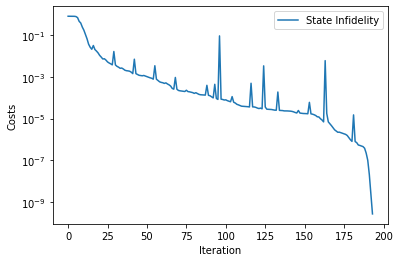

In [83]:
data = DataContainer()
data.append_optim_result(result_qopt)
analyzer = Analyser(data=data)
analyzer.plot_costs()

In [84]:
result_qopt.final_cost

2.7546021019730915e-10

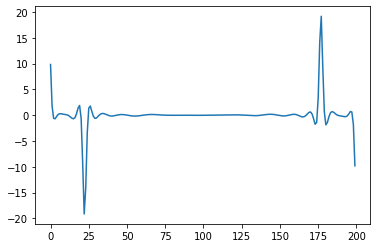

In [85]:
plt.plot(result_qopt.final_parameters / micro_eV_by_inverse_nano_seconds / 1000)

In [86]:
simulator.value_and_gradient(opt_pars=tf.Variable(result_qopt.final_parameters, dtype=DEFAULT_FLOAT_TYPE))[0]


<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.75458101e-10]])>

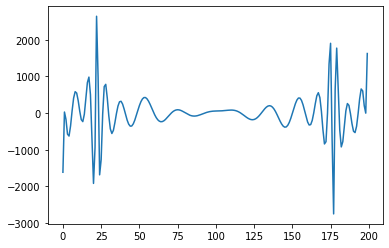

In [87]:
plt.plot(result.x - np.squeeze(result_qopt.final_parameters))

In [88]:
result.fun

2.963974710779027e-05